Epoch 1/100
31/31 [==============================] - 3s 67ms/step - loss: 0.0042 - val_loss: 0.0305
Epoch 2/100
31/31 [==============================] - 2s 57ms/step - loss: 0.0014 - val_loss: 0.0227
Epoch 3/100
31/31 [==============================] - 2s 57ms/step - loss: 0.0014 - val_loss: 0.0184
Epoch 4/100
31/31 [==============================] - 2s 58ms/step - loss: 0.0010 - val_loss: 0.0164
Epoch 5/100
31/31 [==============================] - 2s 57ms/step - loss: 9.4946e-04 - val_loss: 0.0149
Epoch 6/100
31/31 [==============================] - 2s 57ms/step - loss: 9.2278e-04 - val_loss: 0.0164
Epoch 7/100
31/31 [==============================] - 2s 57ms/step - loss: 7.2979e-04 - val_loss: 0.0117
Epoch 8/100
31/31 [==============================] - 2s 56ms/step - loss: 5.2671e-04 - val_loss: 0.0174
Epoch 9/100
31/31 [==============================] - 2s 56ms/step - loss: 7.8264e-04 - val_loss: 0.0093
Epoch 10/100
31/31 [==============================] - 2s 58ms/step - loss: 6.058

/Users/oushilin/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


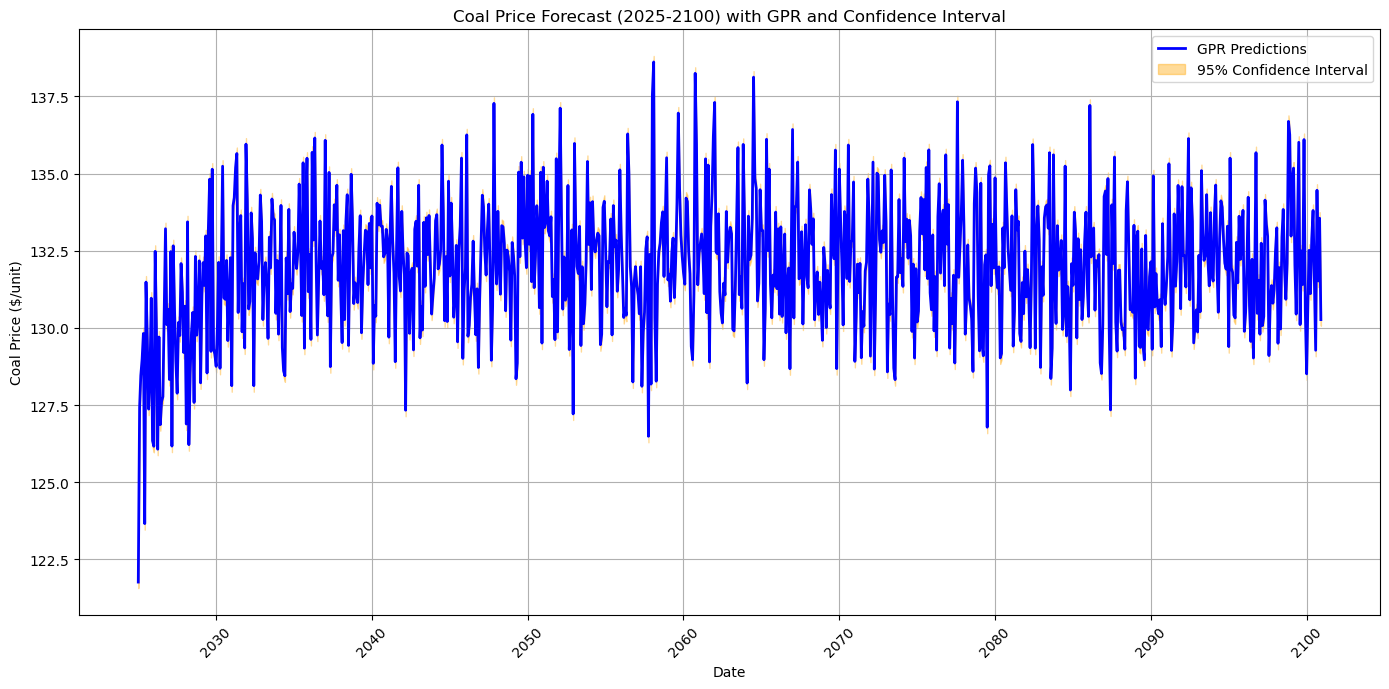


Sample Predictions with Confidence Intervals:
        Date  Prediction    CI Lower    CI Upper
0 2025-01-01  121.764236  121.568243  121.960228
1 2025-02-01  127.428245  127.232285  127.624205
2 2025-03-01  128.456611  128.260694  128.652528
3 2025-04-01  128.987564  128.791678  129.183450
4 2025-05-01  129.820401  129.624539  130.016263
5 2025-06-01  123.658375  123.462530  123.854221
6 2025-07-01  131.485394  131.289556  131.681231
7 2025-08-01  129.582036  129.386199  129.777873
8 2025-09-01  127.369063  127.173238  127.564888
9 2025-10-01  128.412935  128.217116  128.608753


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Load and clean the data
coal_data = pd.read_excel('Average_Coal_Price.xlsx')
# Extract relevant columns and clean
cleaned_data = coal_data.iloc[2:].copy()  # Skip metadata rows
cleaned_data.columns = ['Year_Month', 'Coal_Australian', 'Coal_South_African', 'Average_Coal_Price']
cleaned_data['Date'] = pd.to_datetime(cleaned_data['Year_Month'], format='%YM%m', errors='coerce')
cleaned_data['Average_Coal_Price'] = pd.to_numeric(cleaned_data['Average_Coal_Price'], errors='coerce')
cleaned_data = cleaned_data[(cleaned_data['Date'] >= '1970-01-01') & (cleaned_data['Date'] <= '2024-12-31')]
cleaned_data.dropna(subset=['Date', 'Average_Coal_Price'], inplace=True)

# Keep only the necessary columns
data_cleaned = cleaned_data[['Date', 'Average_Coal_Price']]

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_cleaned['Average_Coal_Price'].values.reshape(-1, 1))

# Function to create time series dataset
def create_dataset(data, time_step=90):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Create the dataset
time_step = 90
X, y = create_dataset(scaled_data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split the data
train_size = int(len(X) * 0.85)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build LSTM model
def build_lstm_model():
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(128, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Train the LSTM model
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
lstm_model = build_lstm_model()
lstm_model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), 
               callbacks=[early_stopping], verbose=1)

# Evaluate the model on the test set
y_test_pred = lstm_model.predict(X_test)

# Inverse transform predictions and actual values
y_test_inverted = scaler.inverse_transform(y_test.reshape(-1, 1))
y_test_pred_inverted = scaler.inverse_transform(y_test_pred)

# Calculate R², MSE, and RMSE for predictions vs actual values
r2_actual = r2_score(y_test_inverted, y_test_pred_inverted)
mse_actual = mean_squared_error(y_test_inverted, y_test_pred_inverted)
rmse_actual = np.sqrt(mse_actual)

# Print evaluation metrics
print("LSTM Model Performance (Predictions vs Actual Values):")
print(f"R-squared: {r2_actual:.4f}")
print(f"MSE: {mse_actual:.4f}")
print(f"RMSE: {rmse_actual:.4f}\n")

# Generate LSTM predictions
def generate_predictions(model, num_predictions=912):  # 912 months = 76 years
    last_90_days = scaled_data[-90:].reshape(1, -1, 1)
    future_dates = pd.date_range(start='2025-01-01', periods=num_predictions, freq='MS')
    future_predictions = []
    for _ in range(len(future_dates)):
        next_prediction = model.predict(last_90_days)
        future_predictions.append(next_prediction[0, 0])
        last_90_days = np.append(last_90_days[:, 1:, :], next_prediction.reshape(1, 1, 1), axis=1)
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
    return future_predictions, future_dates

# LSTM predictions
predictions, future_dates = generate_predictions(lstm_model, num_predictions=912)

# Add Gaussian noise for more robust predictions
def add_gaussian_noise(predictions, stddev=2.0):
    noise = np.random.normal(0, stddev, size=predictions.shape)
    return predictions + noise

predictions_with_noise = add_gaussian_noise(predictions, stddev=2.0)

# Apply Gaussian Process Regression (GPR)
future_dates_numeric = (future_dates - pd.Timestamp('1970-01-01')) // pd.Timedelta('1D')
kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-2)
gpr.fit(future_dates_numeric.values.reshape(-1, 1), predictions_with_noise.flatten())

# GPR predictions with confidence intervals
gpr_predictions, gpr_std = gpr.predict(future_dates_numeric.values.reshape(-1, 1), return_std=True)

# Calculate confidence intervals using gpr_std
ci_upper = gpr_predictions + 1.96 * gpr_std  # 95% confidence interval
ci_lower = gpr_predictions - 1.96 * gpr_std

# Plot GPR predictions with confidence intervals
plt.figure(figsize=(14, 7))
plt.plot(future_dates, gpr_predictions, label='GPR Predictions', color='blue', linewidth=2)
plt.fill_between(future_dates, ci_lower, ci_upper, color='orange', alpha=0.4, label='95% Confidence Interval')
plt.title('Coal Price Forecast (2025-2100) with GPR and Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Coal Price ($/unit)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Save predictions and confidence intervals to CSV
predictions_df = pd.DataFrame({
    'Date': future_dates,
    'Prediction': gpr_predictions,
    'CI Lower': ci_lower,
    'CI Upper': ci_upper
})
predictions_df.to_csv('coal_price_predictions_with_confidence_intervals.csv', index=False)

# Print sample predictions with confidence intervals
print("\nSample Predictions with Confidence Intervals:")
print(predictions_df.head(10))
